<a href="https://colab.research.google.com/github/karunakarsura/yolo-model/blob/main/soil_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1️⃣: Install dependencies
!pip install -q ultralytics==8.* opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00


In [2]:
# Step 2️⃣: Import libraries and verify environment
import ultralytics
ultralytics.checks()

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/112.6 GB disk)


In [3]:
# Step 3️⃣: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Step 4️⃣: Upload your dataset ZIP file (if not already in Drive)
from google.colab import files
import os, zipfile, glob, collections

print("📁 Please upload your dataset ZIP file (e.g., Soil_Types.v1i.yolov11.zip) (skip if already in Drive)")
uploaded = files.upload()

📁 Please upload your dataset ZIP file (e.g., Soil_Types.v1i.yolov11.zip) (skip if already in Drive)


Saving Soil detection.v2i.yolov11.zip to Soil detection.v2i.yolov11.zip


In [5]:
# Step 5️⃣: Unzip dataset to Google Drive folder
DATASET_DIR = "/content/drive/MyDrive/Soil_Types.v1i.yolov11"
os.makedirs(DATASET_DIR, exist_ok=True)

for filename in uploaded.keys():
    print(f"📦 Extracting {filename} ...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
print("✅ Dataset extracted (or already present) at:", DATASET_DIR)

📦 Extracting Soil detection.v2i.yolov11.zip ...
✅ Dataset extracted (or already present) at: /content/drive/MyDrive/Soil_Types.v1i.yolov11


In [6]:
# Step 6️⃣: Verify extracted files
print("Contents of dataset directory:")
!ls -la "{DATASET_DIR}"

# -----------------------------
# NEW: Inspect labels to detect indices & distribution
# -----------------------------
def gather_label_indices(labels_root):
    """Return set of class indices and counts found under labels_root."""
    label_files = glob.glob(os.path.join(labels_root, "**", "*.txt"), recursive=True)
    counts = collections.Counter()
    indices_set = set()
    for lf in label_files:
        try:
            with open(lf, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    # YOLO label format: class x_center y_center width height
                    cls = int(float(parts[0]))
                    counts[cls] += 1
                    indices_set.add(cls)
        except Exception as e:
            print(f"Warning reading {lf}: {e}")
    return indices_set, counts, label_files

# Common label folders (try multiple common names)
label_dirs_to_check = [
    os.path.join(DATASET_DIR, "train", "labels"),
    os.path.join(DATASET_DIR, "train", "label"),
    os.path.join(DATASET_DIR, "train", "annotations"),
    os.path.join(DATASET_DIR, "valid", "labels"),
    os.path.join(DATASET_DIR, "val", "labels"),
    os.path.join(DATASET_DIR, "test", "labels"),
]

found_indices = set()
total_counts = collections.Counter()
all_label_files = []
for d in label_dirs_to_check:
    if os.path.isdir(d):
        inds, counts, files = gather_label_indices(d)
        found_indices.update(inds)
        total_counts.update(counts)
        all_label_files += files

# Print summary
if found_indices:
    print("✅ Found label indices in your dataset:", sorted(found_indices))
    print("Label counts by class index:")
    for idx, cnt in sorted(total_counts.items()):
        print(f"  class {idx} -> {cnt} boxes")
else:
    print("⚠️ No label files found in the common 'labels' locations. Make sure your dataset has label files under (train/labels, valid/labels, test/labels)")


Contents of dataset directory:
total 14
-rw------- 1 root root  315 Oct 17 05:49 data.yaml
-rw------- 1 root root  149 Oct 17 05:49 README.dataset.txt
-rw------- 1 root root  991 Oct 17 05:49 README.roboflow.txt
drwx------ 4 root root 4096 Oct 17 05:21 test
drwx------ 4 root root 4096 Oct 17 05:21 train
drwx------ 4 root root 4096 Oct 17 05:21 valid
✅ Found label indices in your dataset: [0, 1, 2, 3]
Label counts by class index:
  class 0 -> 110 boxes
  class 1 -> 90 boxes
  class 2 -> 45 boxes
  class 3 -> 103 boxes


In [7]:
# Step 7️⃣: Create or repair data.yaml with correct name ordering
import yaml

# --- YOUR desired soil class names in the order you want indices to map to ---
# If your label files use indices 0..3 in that order, this list will match them:
desired_names = ["Clay_Soil", "Red_Soil", "Black_Soil", "Alluvial_Soil"]

# Determine how many classes we need to declare
if found_indices:
    max_index = max(found_indices)
    required_nc = max_index + 1
else:
    # fallback: use length of desired_names
    required_nc = len(desired_names)

# Build final names list of length required_nc
final_names = []
for i in range(required_nc):
    if i < len(desired_names):
        final_names.append(desired_names[i])
    else:
        # generate a fallback name for missing indices
        final_names.append(f"class_{i}")

print("✅ Final names (index -> name):")
for i, n in enumerate(final_names):
    print(f"  {i} -> {n}")

# Paths to train/val/test images (common locations)
train_path = os.path.join(DATASET_DIR, "train", "images")
val_path_candidates = [os.path.join(DATASET_DIR, "valid", "images"), os.path.join(DATASET_DIR, "val", "images")]
val_path = next((p for p in val_path_candidates if os.path.isdir(p)), val_path_candidates[0])
test_path = os.path.join(DATASET_DIR, "test", "images")

data_yaml = {
    'train': train_path,
    'val': val_path,
    'test': test_path,
    'nc': len(final_names),
    'names': final_names
}

yaml_path = os.path.join(DATASET_DIR, "data.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)
print("✅ data.yaml created/updated at:", yaml_path)
print("---- data.yaml contents ----")
!cat "{yaml_path}"
print("---------------------------")




✅ Final names (index -> name):
  0 -> Clay_Soil
  1 -> Red_Soil
  2 -> Black_Soil
  3 -> Alluvial_Soil
✅ data.yaml created/updated at: /content/drive/MyDrive/Soil_Types.v1i.yolov11/data.yaml
---- data.yaml contents ----
names:
- Clay_Soil
- Red_Soil
- Black_Soil
- Alluvial_Soil
nc: 4
test: /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images
train: /content/drive/MyDrive/Soil_Types.v1i.yolov11/train/images
val: /content/drive/MyDrive/Soil_Types.v1i.yolov11/valid/images
---------------------------


In [8]:
# Step 8️⃣: Import YOLO and load model
from ultralytics import YOLO

# Option 1️⃣: Train from scratch
model = YOLO("yolo11n.pt")

# Option 2️⃣: Continue training from previous best model
# model = YOLO("/content/runs/detect/train_soil_types/weights/best.pt")

# NOTE: If you already trained and only prediction names are wrong,
# you can load the trained weights and set model.names before predict:
# model = YOLO("/content/runs/detect/train_soil_types/weights/best.pt")
# model.names = final_names

In [9]:
# Step 9️⃣: Train the model
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    name="train_soil_types",
    project="/content/runs/detect"
)

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Soil_Types.v1i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_soil_types, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

args.yaml			 labels.jpg	      train_batch1.jpg
BoxF1_curve.png			 results.csv	      train_batch2.jpg
BoxP_curve.png			 results.png	      val_batch0_labels.jpg
BoxPR_curve.png			 train_batch0.jpg     val_batch0_pred.jpg
BoxR_curve.png			 train_batch1170.jpg  val_batch1_labels.jpg
confusion_matrix_normalized.png  train_batch1171.jpg  val_batch1_pred.jpg
confusion_matrix.png		 train_batch1172.jpg  weights


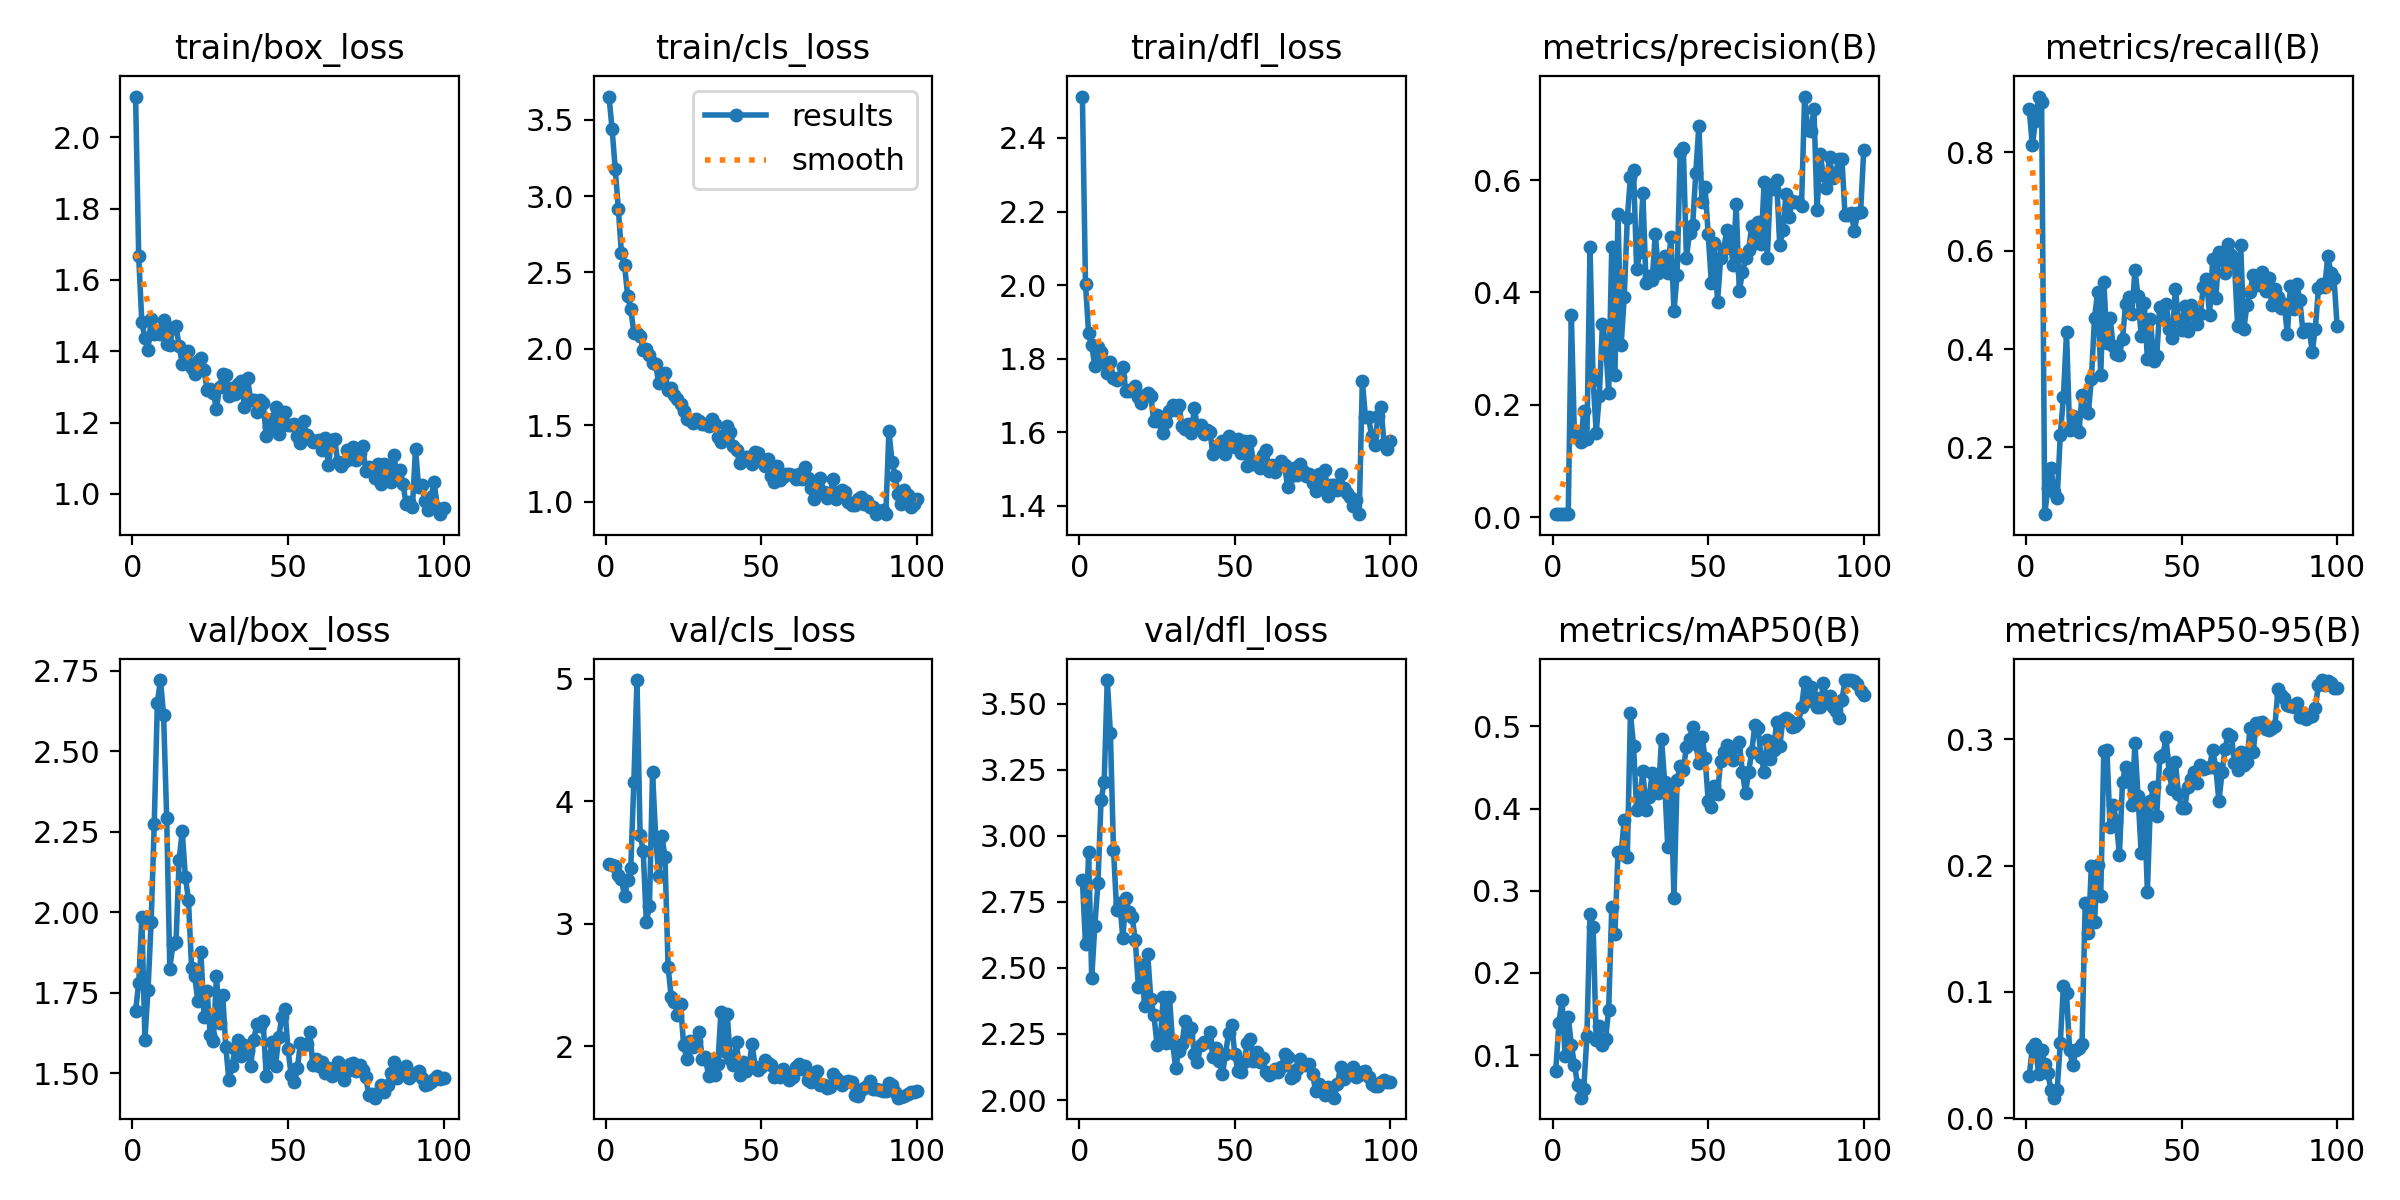

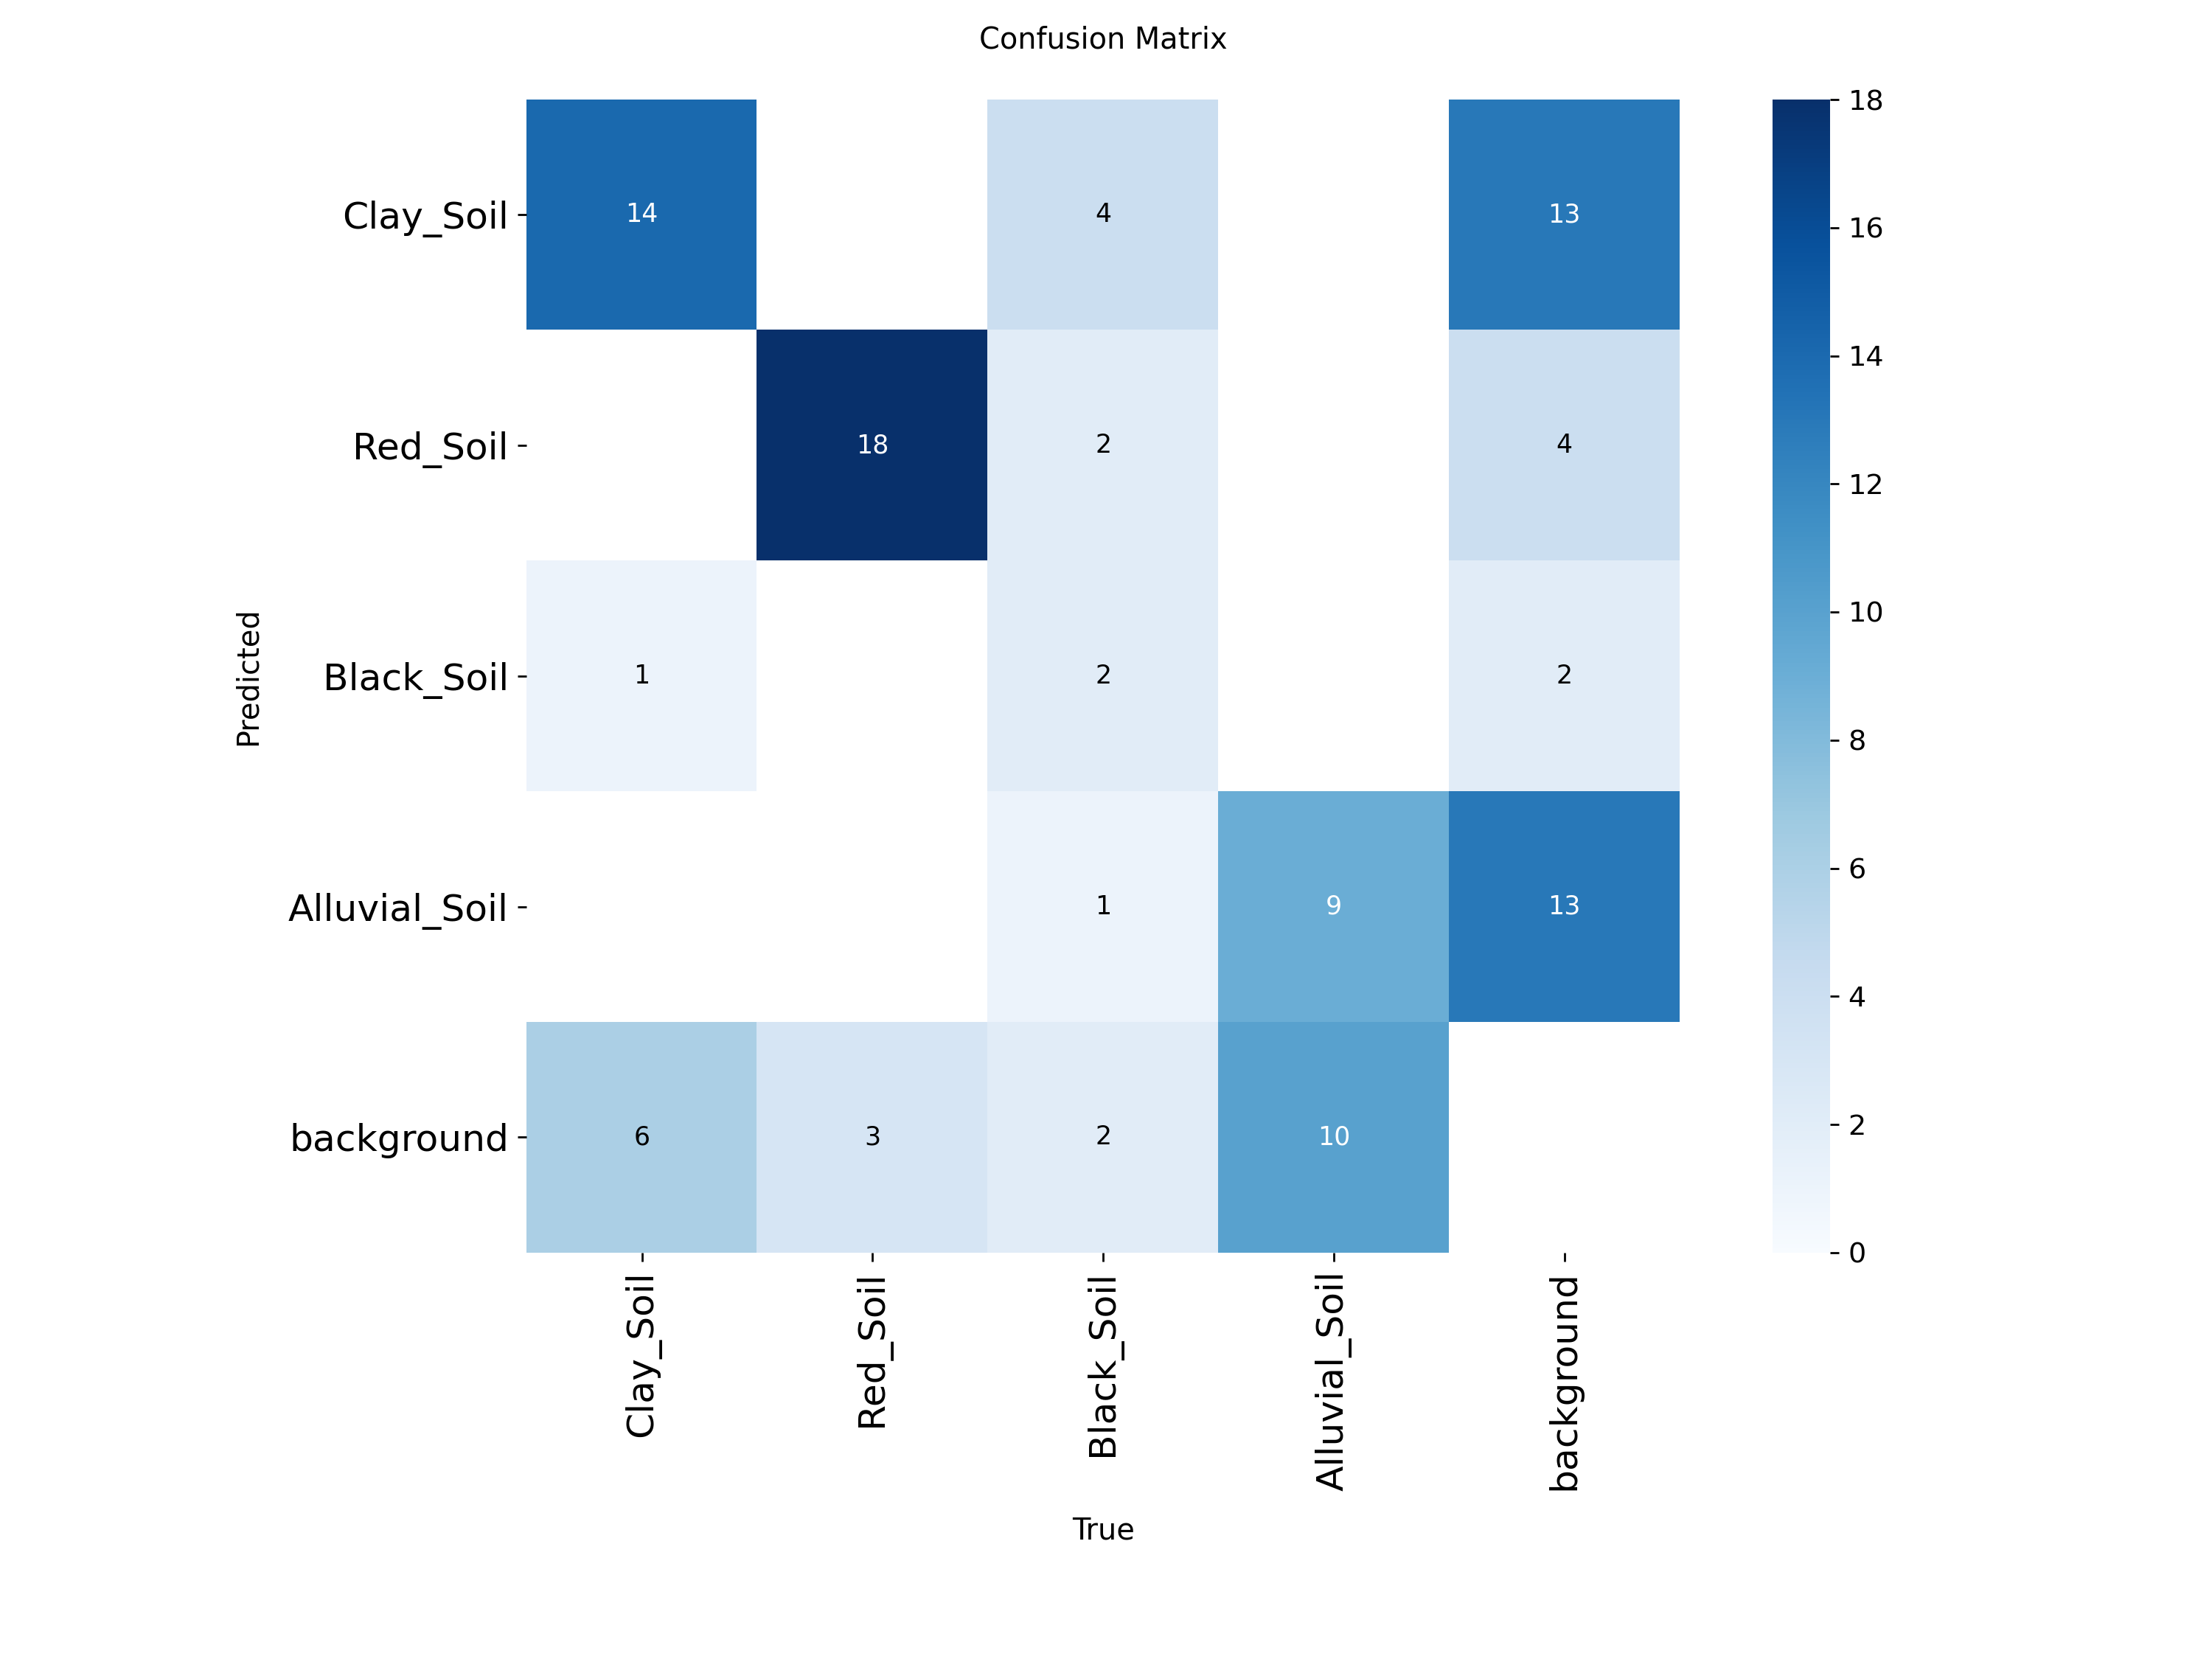

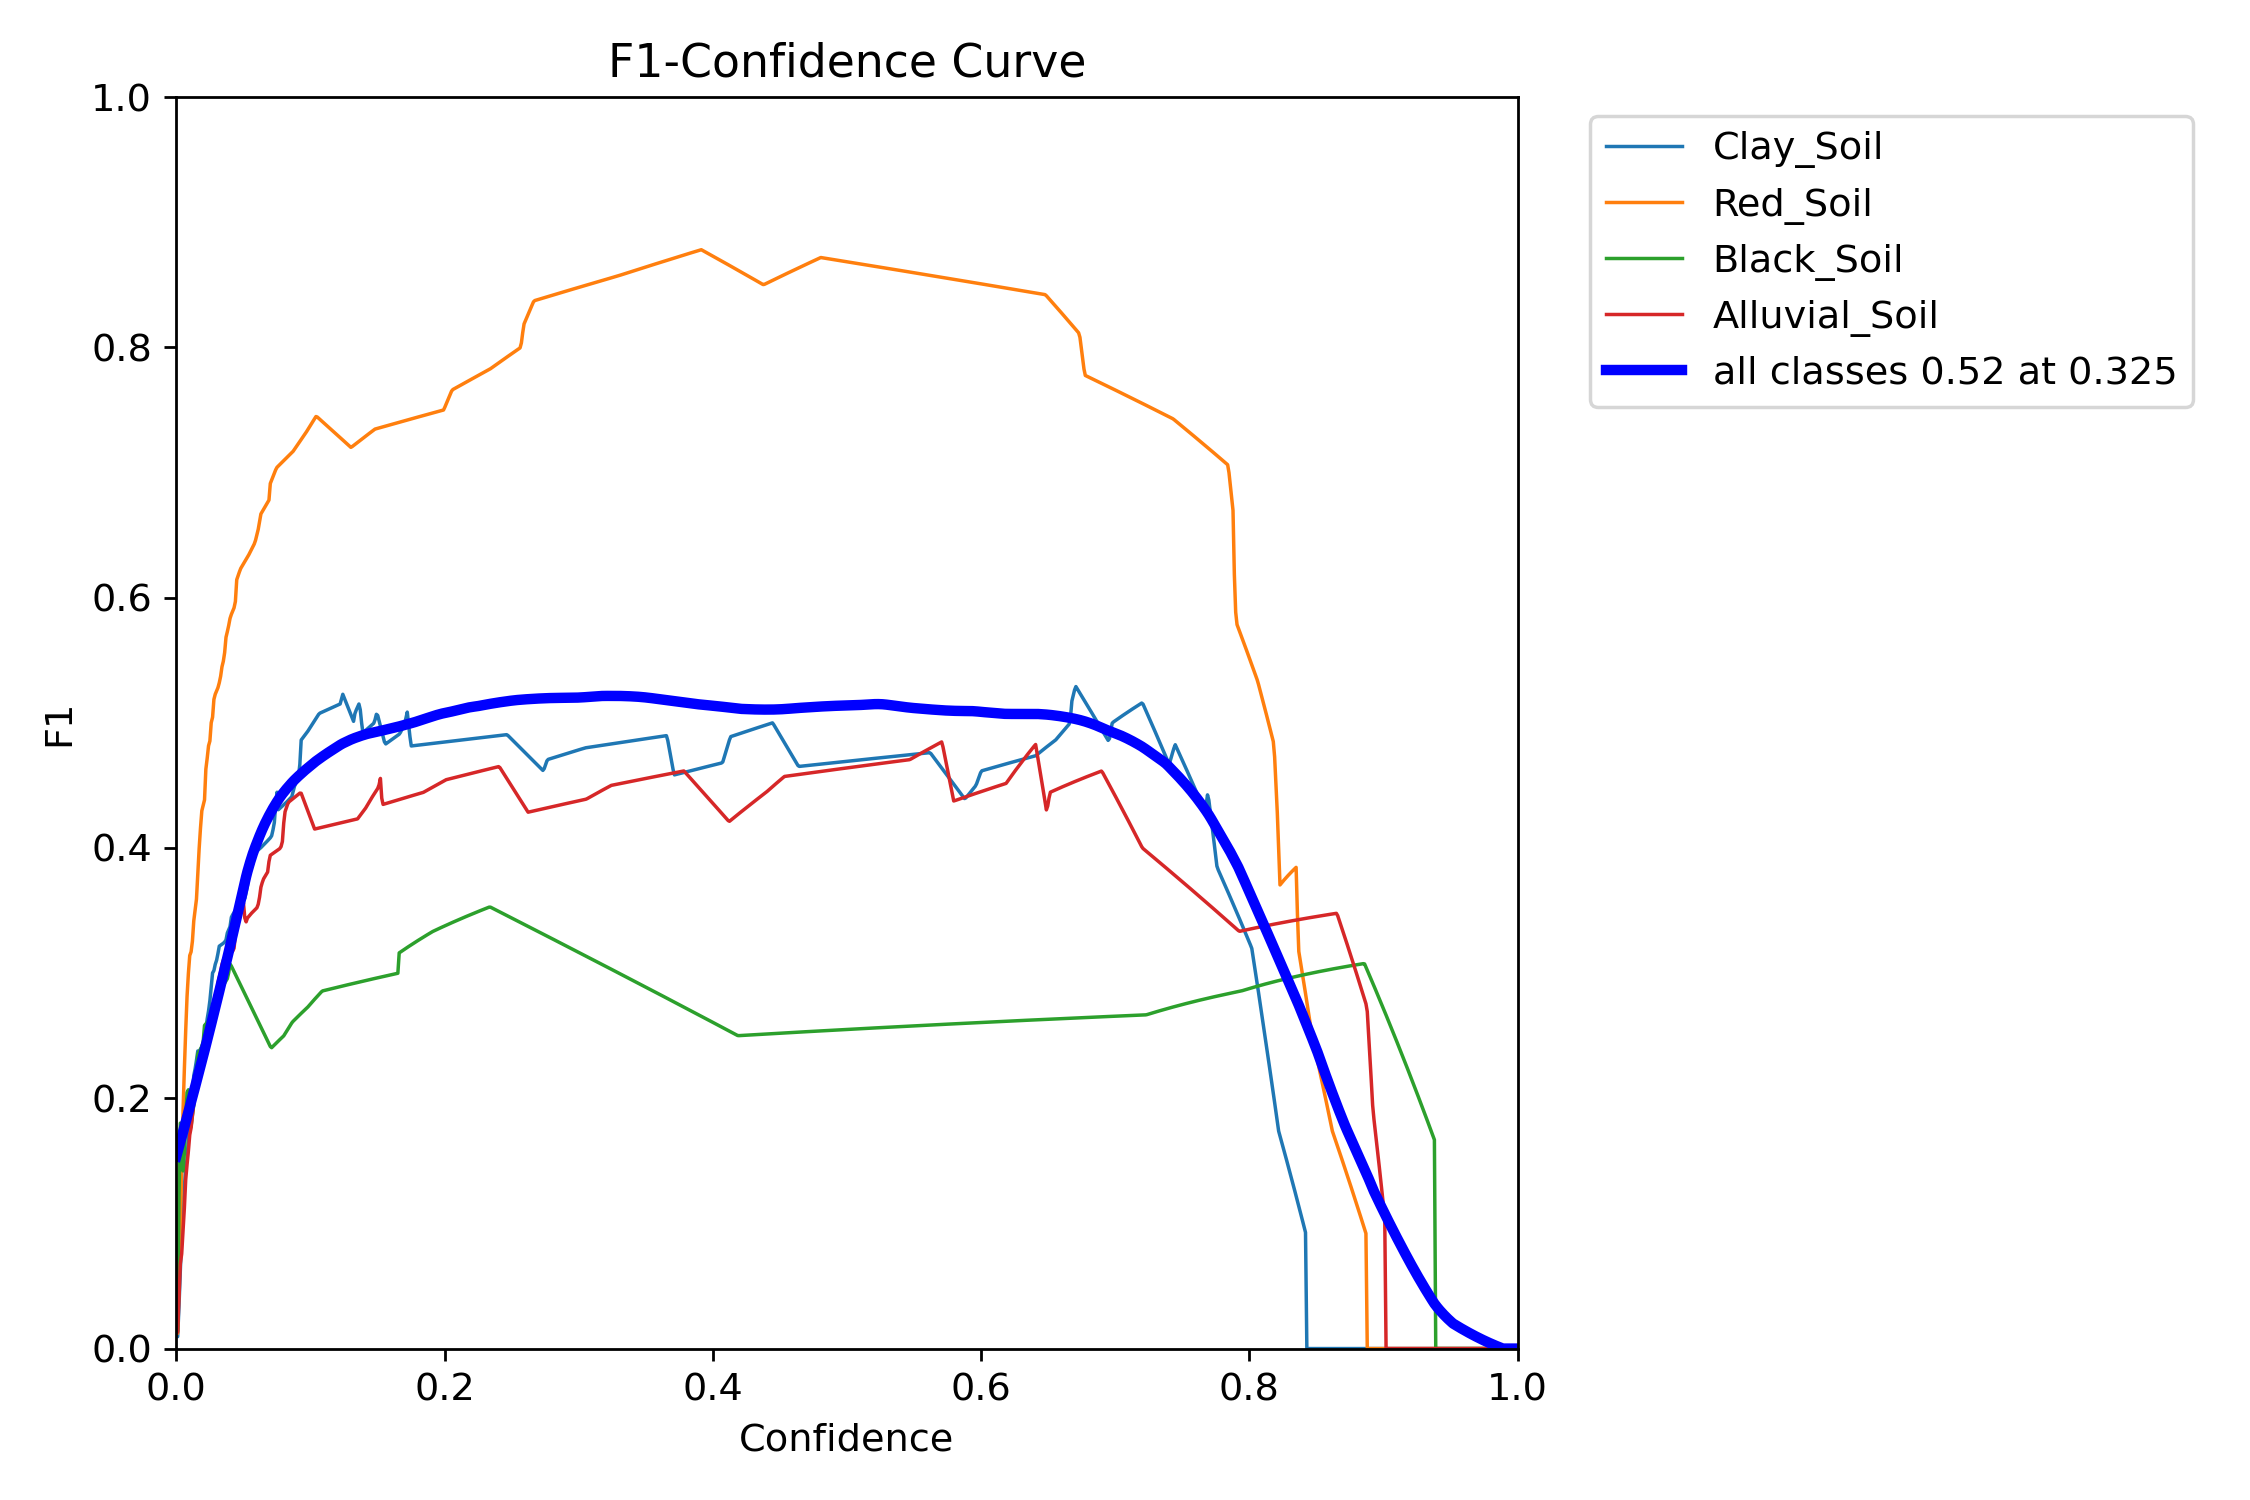

📊 Final Metrics:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
99    100  499.768         0.96167         1.01683          1.5762   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
99               0.65301            0.44588            0.5385   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
99              0.34073        1.4863       1.63008       2.06876  0.000025   

      lr/pg1    lr/pg2  
99  0.000025  0.000025  


AttributeError: property 'names' of 'YOLO' object has no setter

In [10]:
# Step 🔟: Check results directory
!ls '/content/runs/detect/train_soil_types' || true

# Step 1️⃣1️⃣: Visualize training results (if generated)
from IPython.display import Image, display
resultData = '/content/runs/detect/train_soil_types'

# Some files may not exist until training completes; check first
import os
for fname in ["results.png", "confusion_matrix.png", "BoxF1_curve.png"]:
    fpath = os.path.join(resultData, fname)
    if os.path.isfile(fpath):
        display(Image(filename=fpath))
    else:
        print("Note: not found:", fpath)

# Step 1️⃣2️⃣: View metrics (final epoch) if present
import pandas as pd
csv_path = os.path.join(resultData, "results.csv")
if os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
    print("📊 Final Metrics:")
    print(df.tail(1))
else:
    print("No results.csv yet. It will appear after training completes.")

# Step 1️⃣3️⃣: Validate the model
best_weights = os.path.join(resultData, "weights", "best.pt")
if os.path.isfile(best_weights):
    # Load trained model and ensure correct names mapping for prediction/validation
    trained = YOLO(best_weights)
    # attach the final names mapping discovered/created earlier
    trained.names = final_names
    print("✅ Attached correct names to trained model for validation/prediction.")
    # Run validation using ultralytics CLI (this will use trained.names when saving images)
    !yolo task=detect mode=val model="{best_weights}" data="{yaml_path}"
else:
    print("Best weights not found yet at:", best_weights)

# Step 1️⃣4️⃣: Run predictions on test images (will save images with correct names)
if os.path.isdir(test_path) and os.path.isfile(best_weights):
    # ensure model object used for CLI also has the names mapping (Ultralytics CLI uses model file's .yaml,
    # but to be safe we set names and then call predict via python API below)
    trained.names = final_names

    # Option A: Use ultralytics Python API to run predictions and save images with overlayed labels
    preds = trained.predict(source=test_path, conf=0.25, save=True)  # saves to /content/runs/detect/predict by default
    print("✅ Predictions saved to /content/runs/detect/predict (images should show correct class names).")

    # Option B (alternative): use CLI (uncomment if desired)
    # !yolo task=detect mode=predict model="{best_weights}" conf=0.25 source="{test_path}"
else:
    print("Skipping predictions: test path or best weights missing.")
    print(" test_path exists?:", os.path.isdir(test_path))
    print(" best_weights exists?:", os.path.isfile(best_weights))

# Step 1️⃣5️⃣: Display some predictions
import glob
for image_path in glob.glob('/content/runs/detect/predict/*.jpg'):
    display(Image(filename=image_path, height=400))
    print('')

In [11]:
# -----------------------
# Fixed Step 10: Validate trained model and ensure correct names mapping
# -----------------------

from ultralytics import YOLO
import os

best_weights = os.path.join(resultData, "weights", "best.pt")  # resultData set earlier

if os.path.isfile(best_weights):
    # 1) Load the trained model
    best = YOLO(best_weights)

    # 2) Create names mapping as a dict: {index: "ClassName"}
    # final_names is the list you already created earlier, e.g.
    # final_names = ["Clay_Soil", "Red_Soil", "Black_Soil", "Alluvial_Soil"]
    names_dict = {i: name for i, name in enumerate(final_names)}

    # 3) Attach the mapping to the underlying model (this won't raise AttributeError)
    try:
        best.model.names = names_dict
        print("✅ Successfully attached names mapping to best.model.names")
    except Exception as e:
        # Fallback (rare): try setting attribute with setattr
        setattr(best.model, "names", names_dict)
        print("✅ Attached names mapping via setattr (fallback).")

    # 4) Quick check
    print("Model class names mapping:")
    for idx, nm in best.model.names.items():
        print(f"  {idx} -> {nm}")

    # 5) Run validation using the Python API (recommended)
    # This will run validation and print the summary; it will also use the model's names when producing plots/labels.
    print("\n🔎 Running validation (Python API) — this may take a while...")
    val_results = best.val(data=yaml_path, imgsz=640, batch=16, device=None)  # adjust imgsz/batch/device as needed
    print("Validation finished. See returned object for details:")
    print(type(val_results), val_results)  # val_results contains metrics & other info

    # (Optional) If you want the ultralytics CLI validation instead, you can run:
    # !yolo task=detect mode=val model="{best_weights}" data="{yaml_path}"
    # Note: the CLI reads the model file; setting best.model.names above ensures labels produced programmatically are correct.

else:
    print("❌ best.pt not found at:", best_weights)


✅ Successfully attached names mapping to best.model.names
Model class names mapping:
  0 -> Clay_Soil
  1 -> Red_Soil
  2 -> Black_Soil
  3 -> Alluvial_Soil

🔎 Running validation (Python API) — this may take a while...
Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 58.1±20.6 MB/s, size: 86.4 KB)
val: Scanning /content/drive/MyDrive/Soil_Types.v1i.yolov11/valid/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 58/58 114.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.5it/s 2.7s
                   all         58         72      0.538      0.532      0.556      0.347
             Clay_Soil         18         21      0.419      0.571      0.583      0.313
              Red_Soil         17         21      0.856      0.857      

In [12]:
# -----------------------
# Predict on test images (ensures correct overlay names)
# -----------------------
if os.path.isdir(test_path) and os.path.isfile(best_weights):
    # reload to be safe (ensures we're using the mapped names)
    predictor = YOLO(best_weights)
    predictor.model.names = names_dict  # ensure mapping present on this loaded object too

    print("🔮 Running predictions and saving annotated images to /content/runs/detect/predict ...")
    preds = predictor.predict(source=test_path, conf=0.25, save=True, imgsz=640)  # save=True writes images with labels
    print("✅ Predictions complete. Saved images should show the correct class names.")
else:
    print("Skipping predictions: test path or best weights missing.")
    print(" test_path exists?:", os.path.isdir(test_path))
    print(" best_weights exists?:", os.path.isfile(best_weights))


🔮 Running predictions and saving annotated images to /content/runs/detect/predict ...

image 1/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Black_38_jpg.rf.cce2afe5e739cb1d77fbdfd7d51d5012.jpg: 640x640 1 Red_Soil, 9.4ms
image 2/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Black_44_jpg.rf.bfb078e5b0304edb36b2cc1d57ea3cbc.jpg: 640x640 1 Red_Soil, 8.7ms
image 3/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Black_47_jpg.rf.30fa0ac078480d4fbb2bdb6bd4c189c3.jpg: 640x640 1 Red_Soil, 8.4ms
image 4/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Clay_47_jpg.rf.75ea8b632fb8f5e1a540b31945d9ff4d.jpg: 640x640 1 Black_Soil, 8.7ms
image 5/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Copy-of-clay-soil-cropped_jpg.rf.9dfcef24065c2fa79a282f89bff22b80.jpg: 640x640 1 Black_Soil, 8.7ms
image 6/28 /content/drive/MyDrive/Soil_Types.v1i.yolov11/test/images/Copy-of-image14_jpeg.rf.4e376475395c1adc2faba2ce470bf93e.jpg: 640x640 1 Alluvia

✅ Showing 28 prediction result(s):


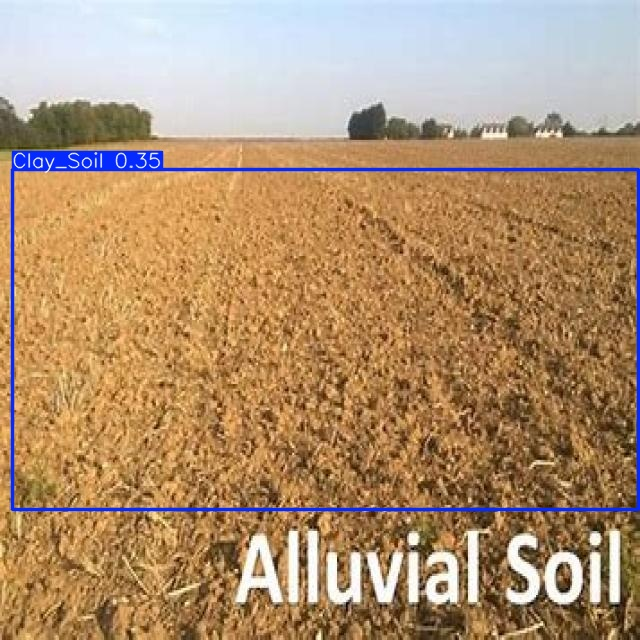

🖼️ OIP-DYv2HhVuCZkJuo6K4NcjgwHaE6_jpg.rf.a8bb88577cd95755f1a788edae3fdcaf.jpg



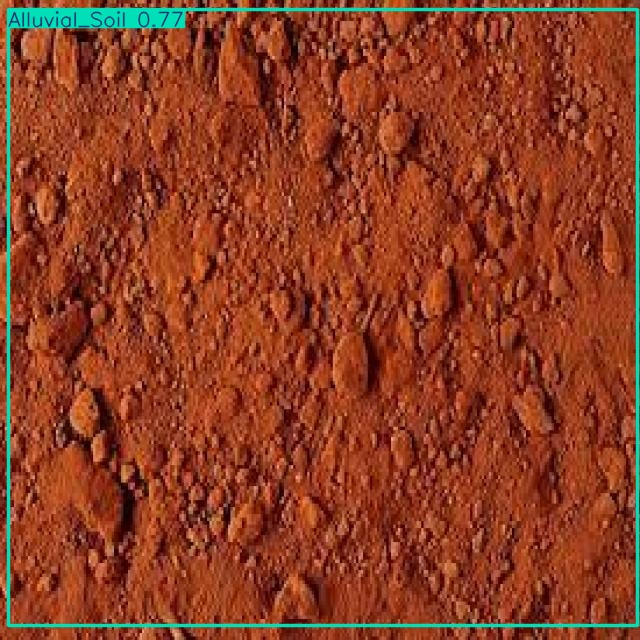

🖼️ Copy-of-image14_jpeg.rf.4e376475395c1adc2faba2ce470bf93e.jpg



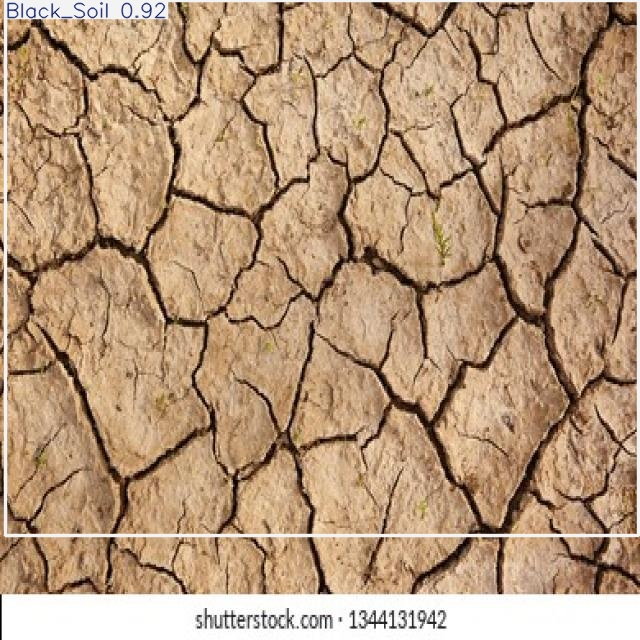

🖼️ texture-dried-earth-clay-sand-260nw-1344131942_jpg.rf.fa25c57e4bc188d33b298abed17ac9f6.jpg



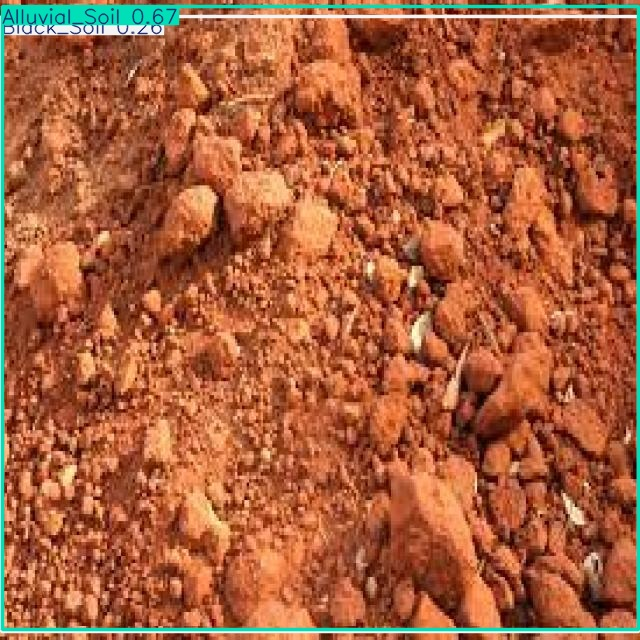

🖼️ Copy-of-image15_jpeg.rf.4dcea00f6cf966d634e331ab311cbdca.jpg



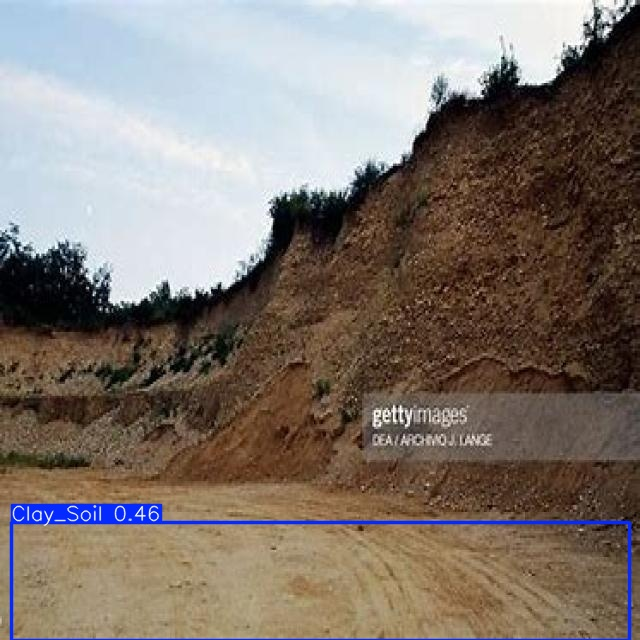

🖼️ OIP-uApXs3Gbx3mU71-BGTLf3gHaE-_jpg.rf.338bfd49f3b7683778e94bc54ffb1804.jpg



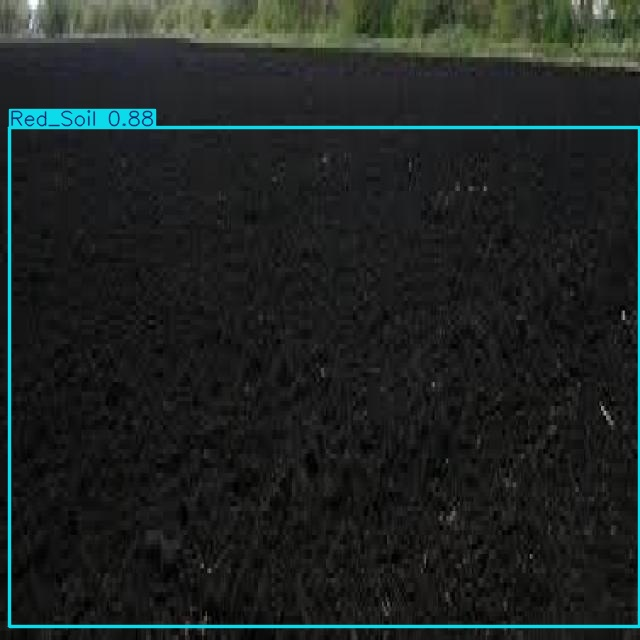

🖼️ Black_47_jpg.rf.30fa0ac078480d4fbb2bdb6bd4c189c3.jpg



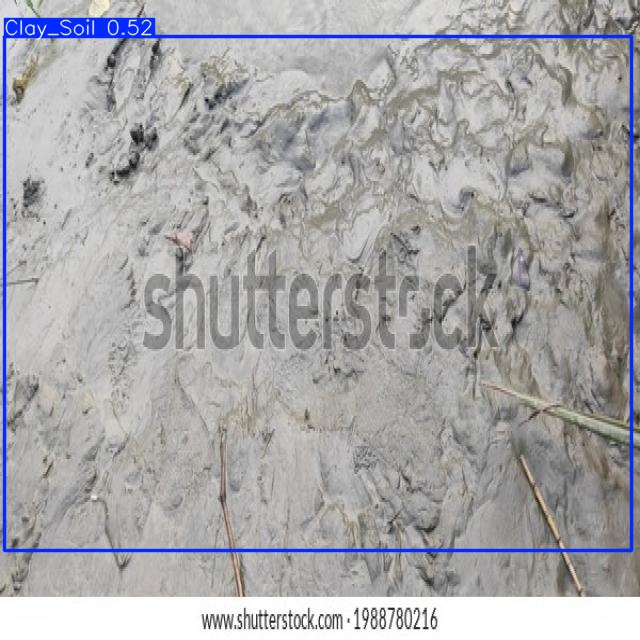

🖼️ alluvial-soil-geographical-study-reference-600w-1988780216_jpg.rf.212572abc4ca1273ec29a6529edd8e83.jpg



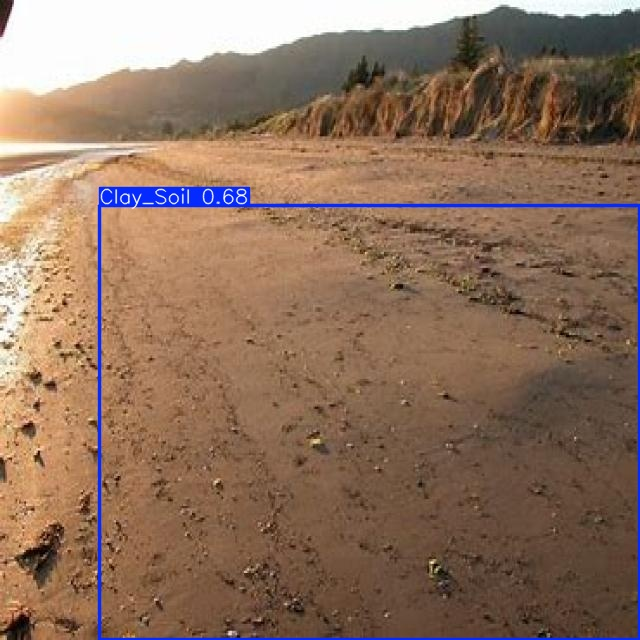

🖼️ OIP-KVkf9QJRKPigCm0hKBI3qAEsDh_jpg.rf.1d286073555a8bb4141a928f57e3c1a7.jpg



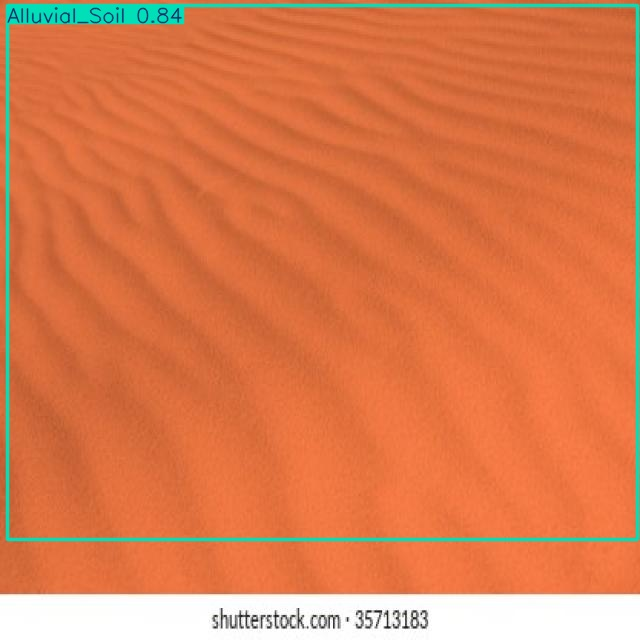

🖼️ red-sand-260nw-35713183_jpg.rf.a6e686ebde584e73b3059993255c0bb6.jpg



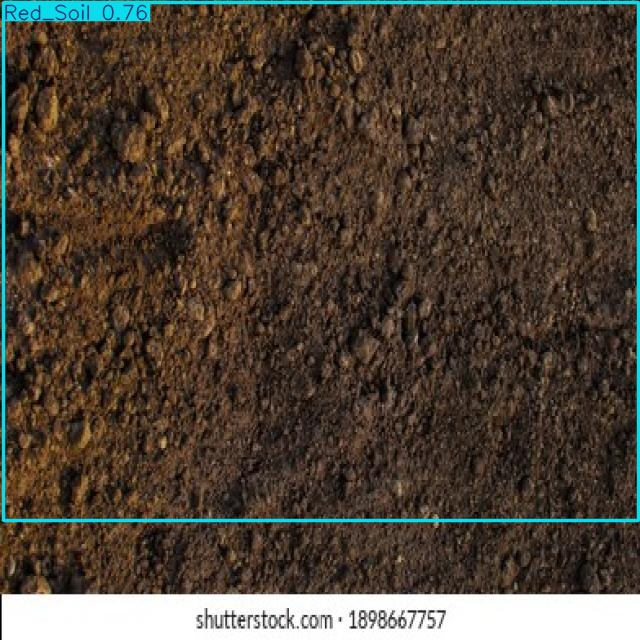

🖼️ brown-soil-texture-background-cultivated-260nw-1898667757_jpg.rf.5acd27a74577427cfe6208a238b19114.jpg



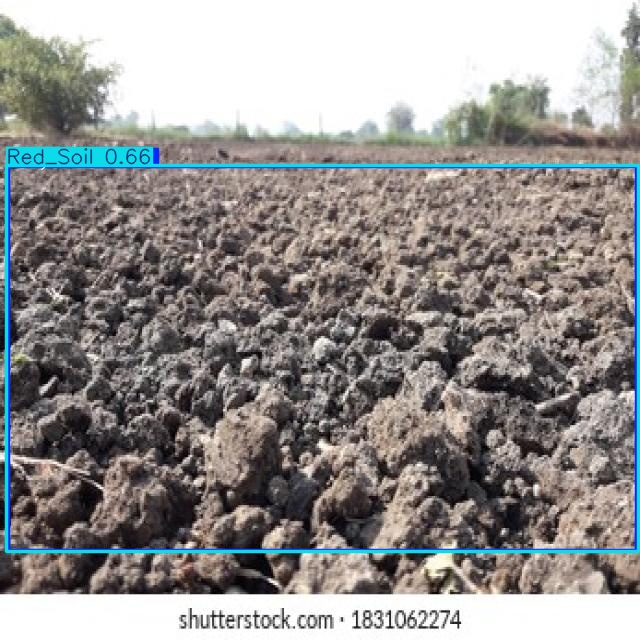

🖼️ closeup-plowed-field-fertile-black-260nw-1831062274_jpg.rf.78ff99b9a89318760278d18356165383.jpg



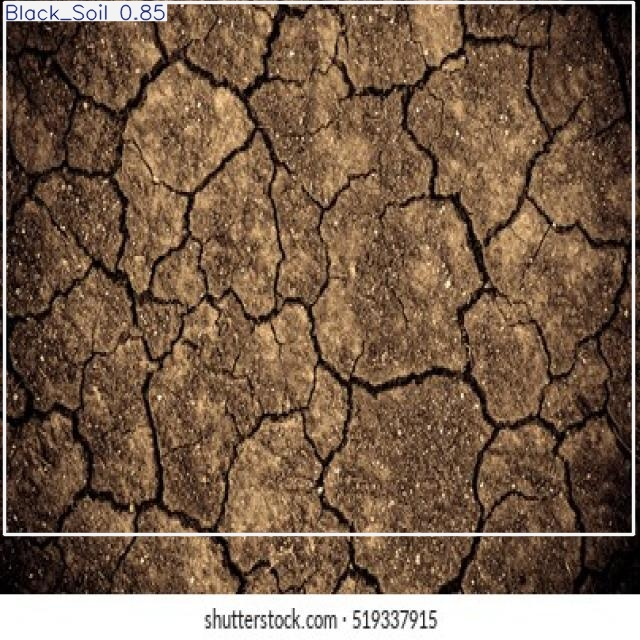

🖼️ dried-cracked-earth-soil-ground-260nw-519337915_jpg.rf.d14cad1c7ef3738d4e1a4a586f7e3e81.jpg



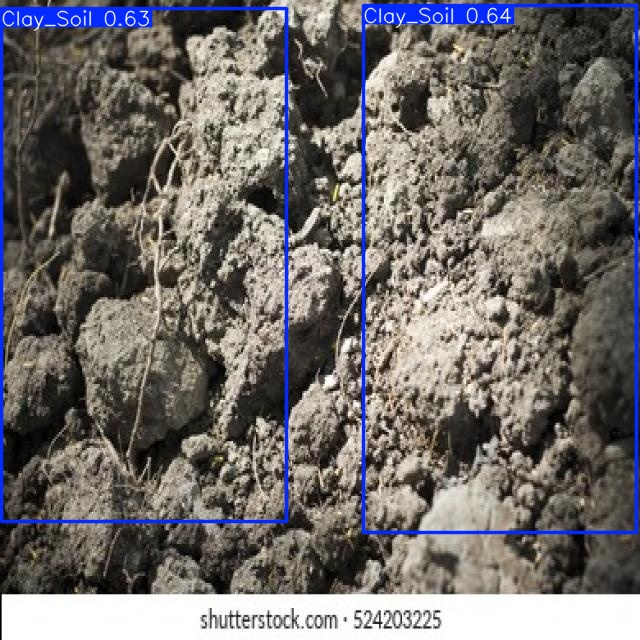

🖼️ closeup-alluvial-soil-texturebackground-260nw-524203225_jpg.rf.6ee841398ad839c9ec9dc5fdda5d4099.jpg



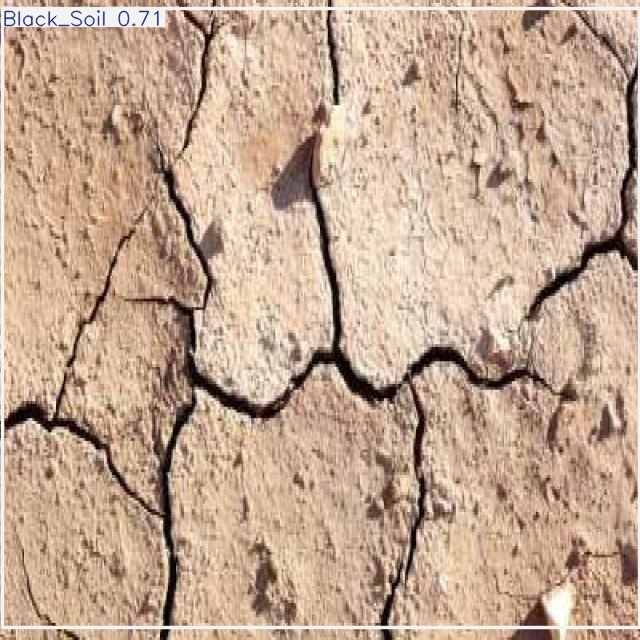

🖼️ Copy-of-clay-soil-cropped_jpg.rf.9dfcef24065c2fa79a282f89bff22b80.jpg



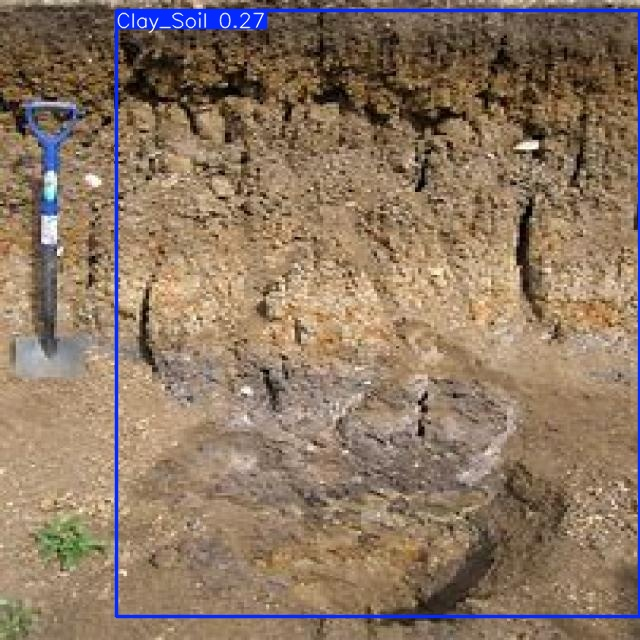

🖼️ OIP-raUzyqtNr7IxQ0aTNBpYYAHaJ4_jpg.rf.5f04ee10efec74d9f7bfc0b3b66e07e5.jpg



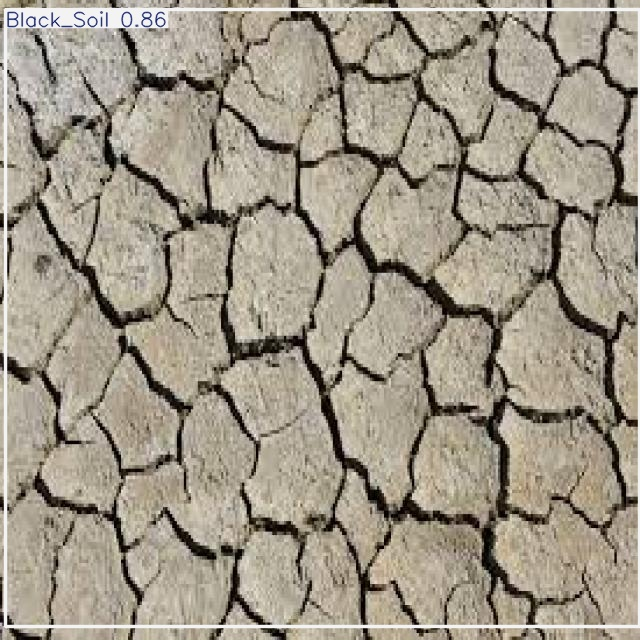

🖼️ Clay_47_jpg.rf.75ea8b632fb8f5e1a540b31945d9ff4d.jpg



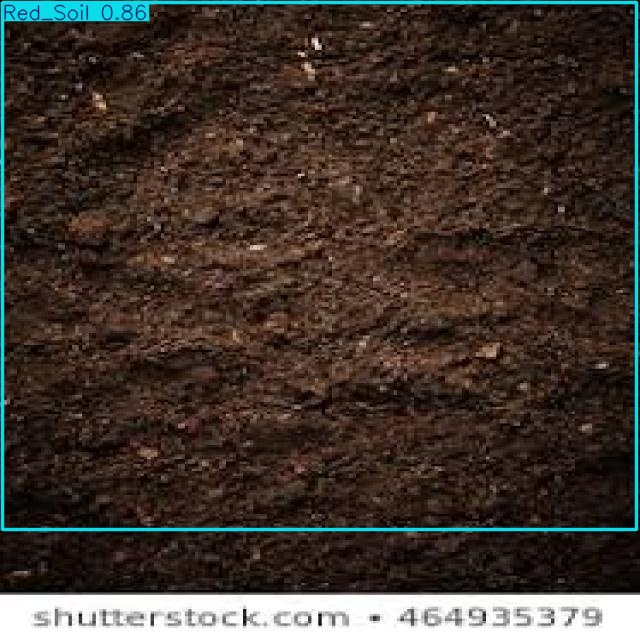

🖼️ Black_38_jpg.rf.cce2afe5e739cb1d77fbdfd7d51d5012.jpg



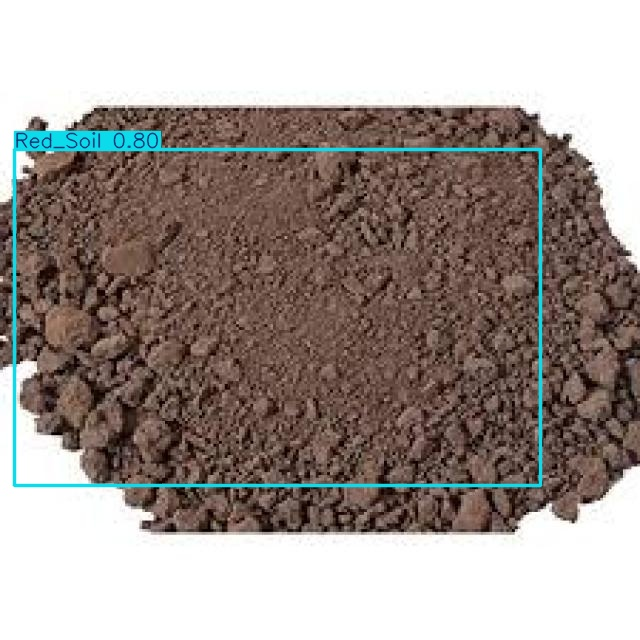

🖼️ Black_44_jpg.rf.bfb078e5b0304edb36b2cc1d57ea3cbc.jpg



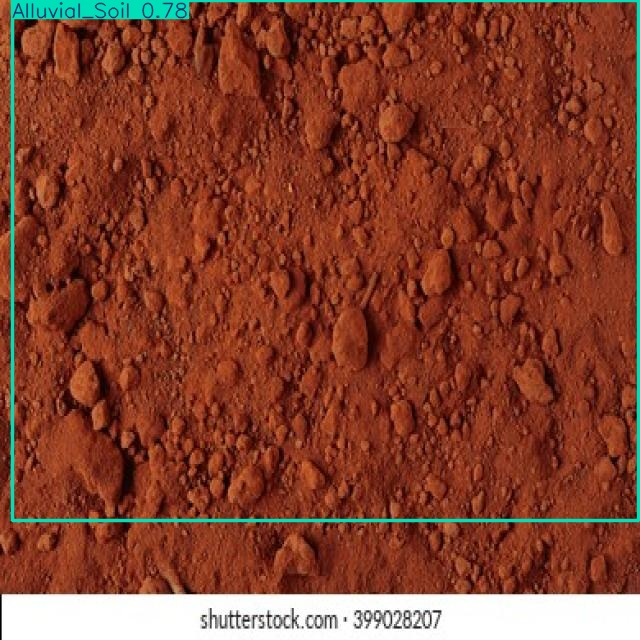

🖼️ ground-texture-top-view-red-260nw-399028207_jpg.rf.1bf7a46c8069046671723ee525d238a7.jpg



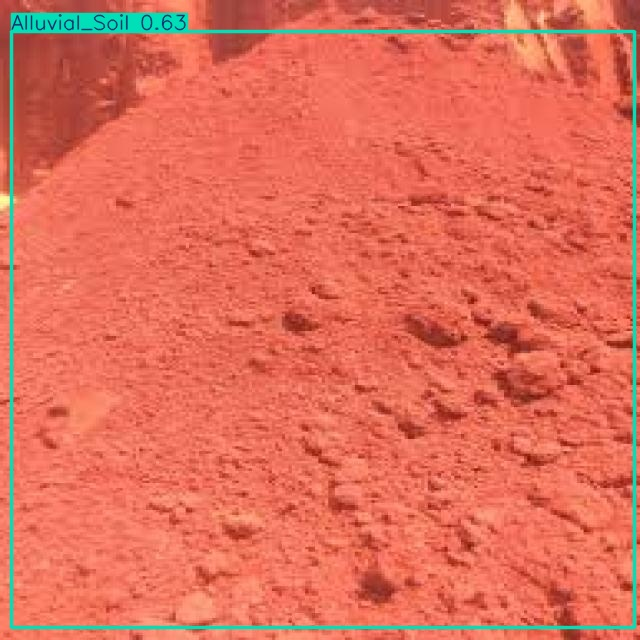

🖼️ Red_44_jpg.rf.166b249f96dfcba4e9996f754ed4ecaf.jpg



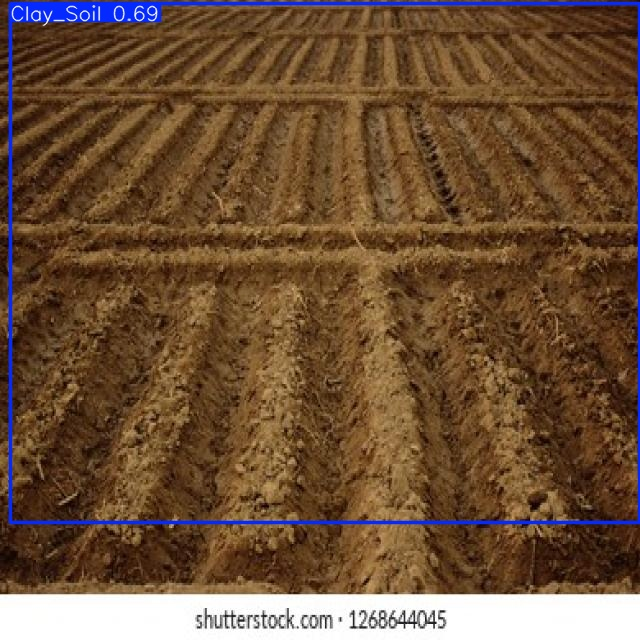

🖼️ seedbed-high-resolution-image-260nw-1268644045_jpg.rf.1b4cb73d0614d4b333ada21923d7aede.jpg



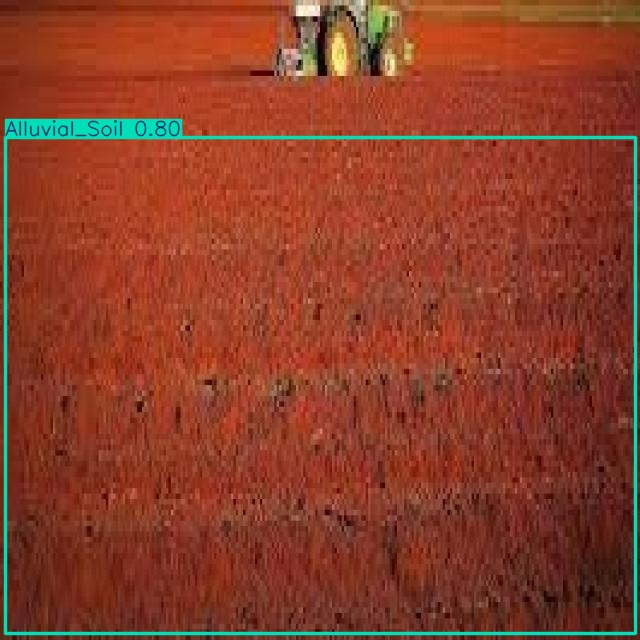

🖼️ Red_43_jpg.rf.65ef688a7c7195195ddaaf0595d44036.jpg



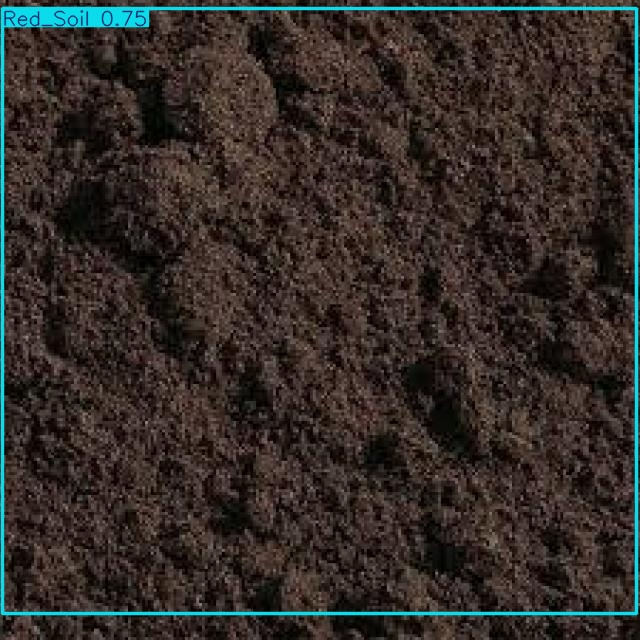

🖼️ Copy-of-images391_jpg.rf.d6806cb6a184655da8cdd3a57cfcd371.jpg



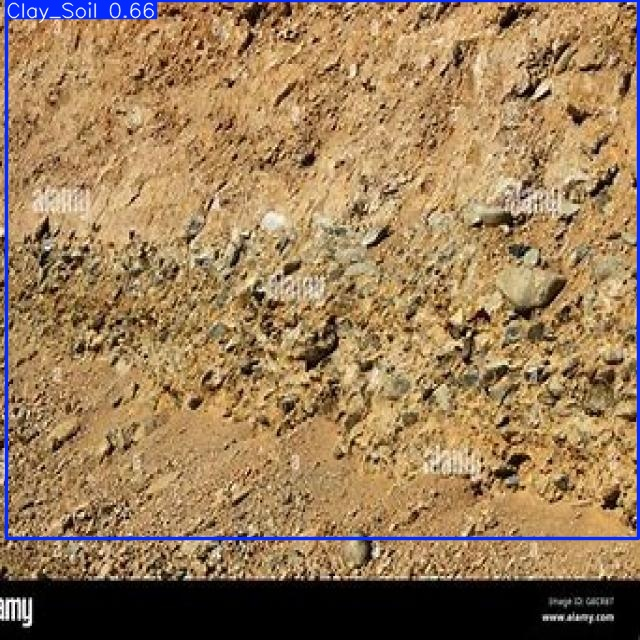

🖼️ OIP-HxR3HmFmEDtRwv49xNa6tAHaFc_jpg.rf.3e0b4def7e54f277d2085d8e99237e23.jpg



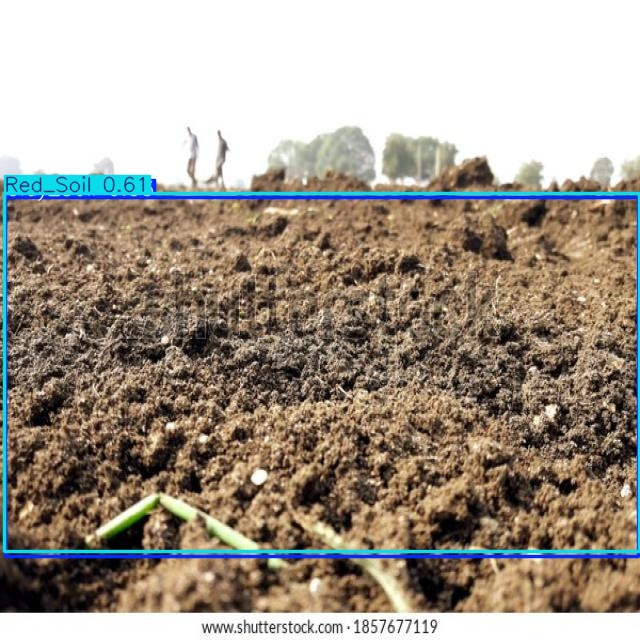

🖼️ soil-upper-layer-earth-which-600w-1857677119_jpg.rf.5f603136d0837aac5e26e4f5efd312e4.jpg



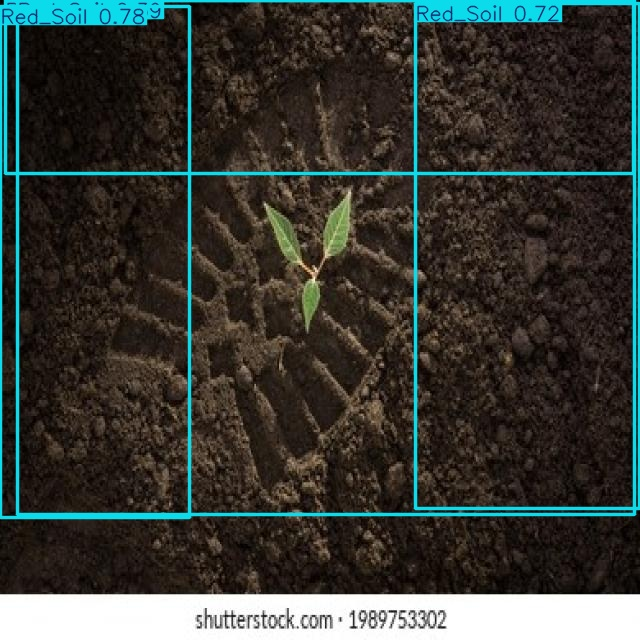

🖼️ footprint-on-ground-soil-green-260nw-1989753302_jpg.rf.471b75f9a457fe6b2b930f03a526681c.jpg



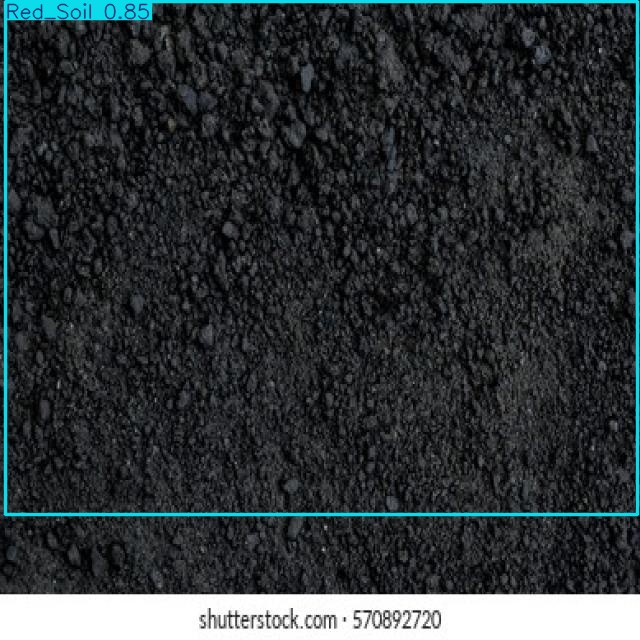

🖼️ closeup-black-color-soil-texture-260nw-570892720_jpg.rf.a63db07d023f79d6c7c0a4afac5e5c5e.jpg



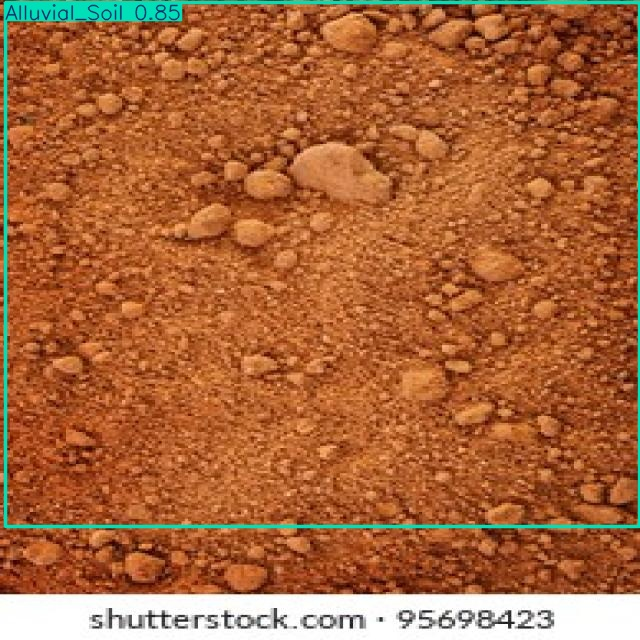

🖼️ vertical-texture-red-dry-clay-260nw-95698423_jpg.rf.84b5a11a0df3b6a6218f7db86afb31d6.jpg



In [13]:
# -----------------------
# Step 11️⃣: Display Predicted Output Images
# -----------------------
import glob
from IPython.display import Image, display

# Path where YOLO saves predictions (default)
PRED_DIR = "/content/runs/detect/predict"

# Check if predictions exist
image_files = glob.glob(f"{PRED_DIR}/*.jpg") + glob.glob(f"{PRED_DIR}/*.png")

if len(image_files) == 0:
    print("⚠️ No prediction images found. Run the prediction step again to generate results.")
else:
    print(f"✅ Showing {len(image_files)} prediction result(s):")
    for img_path in image_files:
        display(Image(filename=img_path, height=400))
        print(f"🖼️ {os.path.basename(img_path)}\n")
